In [1]:
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
from pathlib import Path
from OAS2_data import OAS2Data

# Load Data

In [2]:
data = OAS2Data(size=3, data_type='eval') # 9 mins to run 3
img, lab = data[26]
img, lab

Loaded Labels and Images for eval


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 1)

In [3]:
class_names = data.classes
class_names

['Nondemented', 'Demented']

# Evaluation Split Batches

In [4]:
torch.manual_seed(310)
BATCH_SIZE = 16
test_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Length of test dataloader: 364 batches of 16


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Loss Function

In [6]:
loss_fn = nn.CrossEntropyLoss()
# loss = nn.BCEWithLogitsLoss()

# Load ResNet Models

In [7]:
def load_model(model: nn.Module, 
               class_names: list, 
               model_type: int,
               state_dict_path,
               device = device,
               ): 
    
    
    model_for_eval = model
    
    if model_type == 1: # ResNet
        first_res_layer = model_for_eval.conv1
    
        model_for_eval.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=first_res_layer.out_channels,
            kernel_size=first_res_layer.kernel_size,
            stride=first_res_layer.stride,
            padding=first_res_layer.padding,
            bias=first_res_layer.bias,
        )
    
        model_for_eval.fc = nn.Linear(model_for_eval.fc.in_features, len(class_names))

    if model_type == 2: # DenseNet

        first_res_layer = model_for_eval.features.conv0

        model_for_eval.features.conv0 = nn.Conv2d(
            in_channels=1,
            out_channels=first_res_layer.out_channels,
            kernel_size=first_res_layer.kernel_size,
            stride=first_res_layer.stride,
            padding=first_res_layer.padding,
            bias=first_res_layer.bias,
        )

        model_for_eval.classifier = nn.Linear(model_for_eval.classifier.in_features, len(class_names))

    # Load in the saved state_dict
    model_for_eval.load_state_dict(torch.load(f=state_dict_path))

    # Send model to GPU
    model_for_eval = model_for_eval.to(device)

    return model_for_eval.eval() # put model in eval mode

# Model configurations

In [8]:
MODEL_CONFIGS = {
    'resnet18': {'model': models.resnet18(weights=None), 'type': 1},
    'resnet50': {'model': models.resnet50(weights=None), 'type': 1},
    'densenet121': {'model': models.densenet121(weights=None), 'type': 2},
    'densenet201': {'model': models.densenet201(weights=None), 'type': 2}
}


model_files = list(Path('fixed_models').glob('*.pth'))


# Iterate through all model files

In [9]:
from sklearn import metrics
results = []

for model_path in model_files:

    name = model_path.stem
    base_model = name.split('_')[0]  # Gets the name 'resnet50'
    batch_size = name.split('btch')[1].split('_')[0]  # Gets the batch size '16'
    dataset_size = name.split('dst')[1].split('_')[0]  # Gets the dataset size '3'

    print(f"Evaluating model: {base_model}, Batch Size: {batch_size}, Dataset Size: {dataset_size}")
    
    
    for model_name, config in MODEL_CONFIGS.items():
        if model_name in base_model.lower():
            
            model = load_model(
                model=config['model'],
                class_names=data.classes,
                state_dict_path=model_path,
                model_type=config['type'],
                device=device
            )
            
            with torch.inference_mode():
                test_loss = 0
                test_acc = 0
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    # acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
                    acc = metrics.accuracy_score(y.cpu(), y_pred.argmax(dim=1).cpu())
                    prec = metrics.precision_score(y.cpu(), y_pred.argmax(dim=1).cpu(), average='weighted', zero_division=0)
                    rec = metrics.recall_score(y.cpu(), y_pred.argmax(dim=1).cpu(), average='weighted', zero_division=0)
                    f1 = metrics.f1_score(y.cpu(), y_pred.argmax(dim=1).cpu(), average='weighted', zero_division=0)
                    test_loss = loss.item()
                    test_acc = acc
                
                results.append({
                    'Model': base_model,
                    'Dataset Size': dataset_size,
                    'Batch Size': batch_size,
                    'Loss': test_loss,
                    'Accuracy': test_acc,
                    'Precision': prec,
                    'Recall': rec,
                    'F1 Score': f1
                })


Evaluating model: densenet121, Batch Size: 16, Dataset Size: 1
Evaluating model: densenet121, Batch Size: 16, Dataset Size: 3
Evaluating model: densenet201, Batch Size: 16, Dataset Size: 1
Evaluating model: resnet18, Batch Size: 16, Dataset Size: 1
Evaluating model: resnet18, Batch Size: 32, Dataset Size: 3
Evaluating model: resnet50, Batch Size: 16, Dataset Size: 1
Evaluating model: resnet50, Batch Size: 16, Dataset Size: 3
Evaluating model: resnet50, Batch Size: 32, Dataset Size: 3


# Convert results to DataFrame for nice display

In [10]:
import pandas as pd
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Accuracy', ascending=False)
display(df_results)

,Model,Dataset Size,Batch Size,Loss,Accuracy,Precision,Recall,F1 Score
1,densenet121,3,16,0.000507,1.000000,1.0,1.000000,1.000000
6,resnet50,3,16,0.052853,1.000000,1.0,1.000000,1.000000
5,resnet50,1,16,0.643573,0.833333,1.0,0.833333,0.909091
0,densenet121,1,16,0.892065,0.500000,1.0,0.500000,0.666667
2,densenet201,1,16,2.183665,0.000000,0.0,0.000000,0.000000
3,resnet18,1,16,0.875446,0.000000,0.0,0.000000,0.000000
4,resnet18,3,32,NaN,0.000000,0.0,0.000000,0.000000
7,resnet50,3,32,NaN,0.000000,0.0,0.000000,0.000000


# Create bar plot of accuracies

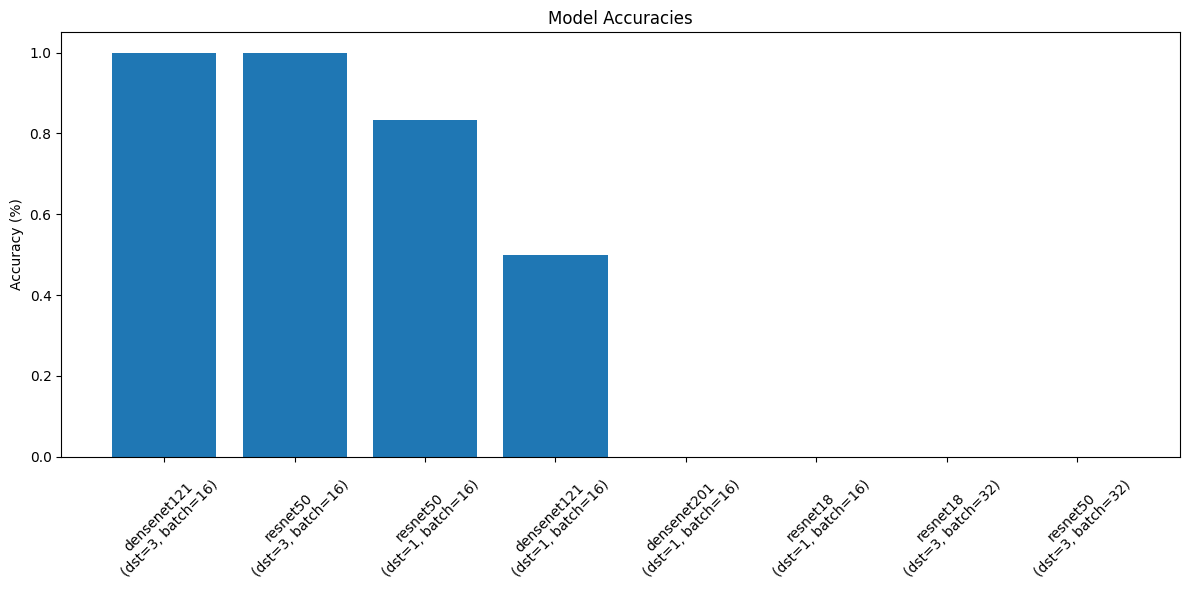

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(results)), df_results['Accuracy'])
plt.xticks(range(len(results)), 
           [f"{m}\n(dst={d}, batch={b})" for m, d, b in 
            zip(df_results['Model'], df_results['Dataset Size'], df_results['Batch Size'])],
           rotation=45)
plt.title('Model Accuracies')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

# Make some more predictions

In [12]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension

            # Forward pass 
            pred_logit = model(sample)

            # Get prediction probability 
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 

            # Get pred_prob 
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [13]:
res_model = load_model(model=models.resnet50(weights=None),
           class_names=data.classes,
           state_dict_path=f'fixed_models/resnet50_dst1_btch{BATCH_SIZE}_e10.pth',
           model_type=1,
           device=device)

In [14]:
dense_model = load_model(model=models.densenet121(weights=None),
           class_names=data.classes,
           state_dict_path=f'fixed_models/densenet121_dst1_btch{BATCH_SIZE}_e10.pth',
           model_type=2,
           device=device)

In [15]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 256, 256])
Test sample label: 0 (Nondemented)


In [16]:
# make predictions on test samples with model 2
pred_probs = make_predictions(model=dense_model,
                              data=test_samples)

pred_probs

tensor([[0.0263, 0.9737],
        [0.0543, 0.9457],
        [0.9970, 0.0030],
        [0.9473, 0.0527],
        [0.3633, 0.6367],
        [0.5108, 0.4892],
        [0.9898, 0.0102],
        [0.0154, 0.9846],
        [0.7312, 0.2688]])

In [17]:
# Turn the prediction probabilities into prediction labels by taking the argmax
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 1, 0, 0, 1, 0, 0, 1, 0])

In [18]:
test_labels, pred_classes

([0, 0, 1, 1, 0, 0, 1, 0, 1], tensor([1, 1, 0, 0, 1, 0, 0, 1, 0]))

# Plot predictions

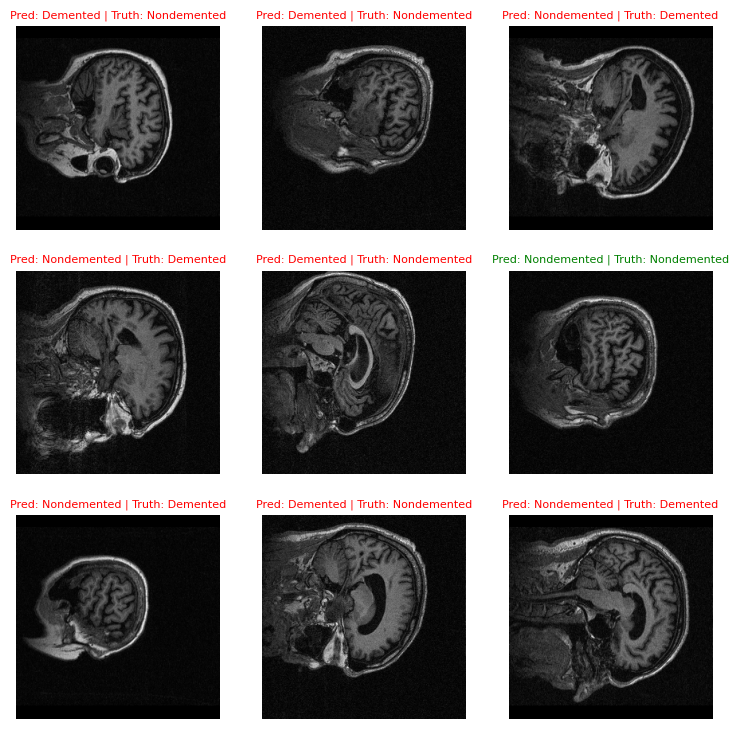

In [19]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=8, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=8, c="r") # red text if wrong
  plt.axis(False);

# Confusion Matrix predictions

In [20]:

# 1. Make predictions with trained model
y_preds = []
dense_model.eval()
with torch.inference_mode():
  for X, y in test_loader:
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = dense_model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

In [21]:
test_labels = []
for _, label in test_loader:
    test_labels.append(label)
test_labels = torch.cat(test_labels)

Text(0.5, 1.0, 'Confusion Matrix for DenseNet121 Model')

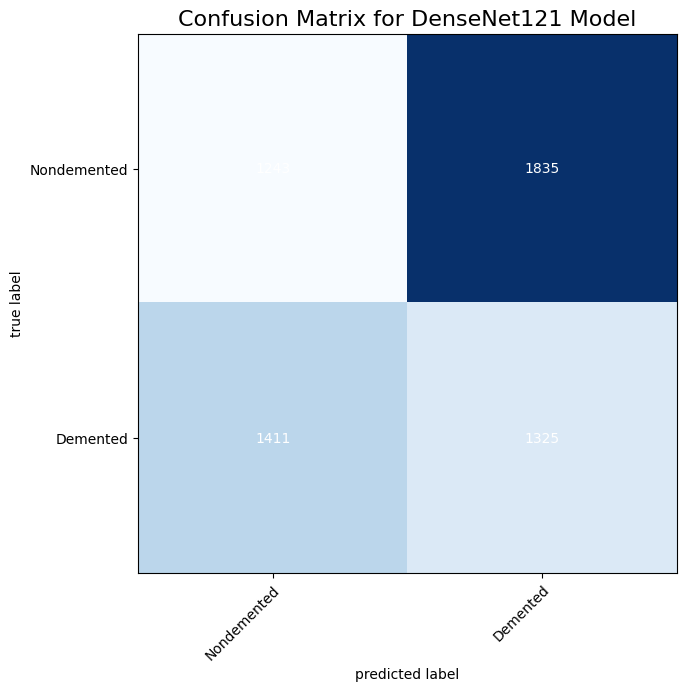

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplot likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)
ax.set_title("Confusion Matrix for DenseNet121 Model", fontsize=16)